In [42]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio


In [43]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
x_metric = "compute_budget"
tag = x_metric
runs = api.runs(entity + "/" + project, filters={"tags": {"$in": [tag]}})
runs

<Runs ajzero/AlphaZero>

In [44]:
# crete a dataframe from runs and summary metrics

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

df


100%|██████████| 45/45 [00:00<00:00, 68286.43it/s]


,Self_Play/Entropies,Self_Play/Min_Timesteps,_runtime,_wandb,Training/Value_loss,Self_Play/Runtime_per_Timestep,Training/Value_Simularities,Training/Policy_loss,Self_Play/Total_Runtime,_step,...,expansion_policy,n_steps_learning,selection_policy,value_loss_weight,max_episode_length,policy_loss_weight,sample_batch_ratio,regularization_weight,tree_evaluation_policy,replay_buffer_multiplier
0,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",13,719.582939,{'runtime': 719},1.583231,5048.192308,8.072363e-02,0.223953,525012,14,...,fromprior,1,PolicyPUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
1,"{'_type': 'histogram', 'bins': [0.339100408554...",20,561.448827,{'runtime': 559},0.835691,3836.077295,1.540810e-02,0.305739,794068,14,...,fromprior,1,PUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
2,"{'_type': 'histogram', 'bins': [0.134722359040...",17,673.500958,{'runtime': 672},2.080371,5203.020979,1.691350e-01,0.173752,744032,14,...,fromprior,1,PUCT,1,200,30,1,0.0001,default,10
3,"{'bins': [0.10825780232747396, 0.1085229634410...",13,284.802109,{'runtime': 283},1.940431,371.570175,2.035624e-06,0.210218,42359,14,...,fromprior,1,PolicyPUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
4,"{'_type': 'histogram', 'bins': [0.128927146687...",17,390.842447,{'runtime': 389},3.095002,483.621622,2.513200e-01,0.176966,71576,14,...,fromprior,1,PUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
5,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",17,349.381559,{'runtime': 347},3.795451,5539.040541,1.158320e-01,0.246129,819778,14,...,fromprior,1,PUCT,1,200,30,1,0.0001,default,10
6,"{'_type': 'histogram', 'bins': [0.325557619333...",13,176.369739,{'runtime': 175},0.653887,842.896825,3.490261e-05,0.293216,106205,14,...,fromprior,1,PolicyPUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
7,"{'values': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...",19,198.454816,{'runtime': 197},0.641601,3193.807882,1.454422e-02,0.255666,648343,14,...,fromprior,1,PUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
8,"{'_type': 'histogram', 'values': [2, 0, 0, 0, ...",17,197.716082,{'runtime': 196},27.356403,4333.569231,1.339812e-01,0.310343,845046,14,...,fromprior,1,PUCT,1,200,30,1,0.0001,default,10
9,"{'bins': [0.053114703068366416, 0.053223417759...",13,579.657024,{'runtime': 578},2.146777,2109.824074,5.291726e-02,0.250268,227861,14,...,fromprior,1,PolicyPUCT,1,200,30,1,0.0001,minimal_variance_constraint,10


In [59]:
df.columns

Index(['Self_Play/Entropies', 'Self_Play/Min_Timesteps', '_runtime', '_wandb',
       'Training/Value_loss', 'Self_Play/Runtime_per_Timestep',
       'Training/Value_Simularities', 'Training/Policy_loss',
       'Self_Play/Total_Runtime', '_step', 'Self_Play/Mean_Timesteps',
       'Self_Play/Max_Reward', 'Self_Play/Total_Timesteps',
       'Training/Learning_Rate', 'Self_Play/Rewards',
       'Self_Play/Total_Average_Reward', 'Self_Play/Cumulative_Reward',
       'Self_Play/Min_Reward', 'Self_Play/Reward_STD', 'Self_Play/Mean_Reward',
       'Self_Play/Timesteps_STD', 'Self_Play/Mean_Entropy',
       'Self_Play/EMA_Reward', 'Training/Value_and_Policy_loss',
       'Training/Replay_Buffer_Size', '_timestamp',
       'Training/Regularization_loss', 'Self_Play/Timesteps', 'env_id',
       'layers', 'puct_c', 'lr_gamma', 'eval_param', 'hidden_dim',
       'iterations', 'model_type', 'norm_layer', 'activation_fn',
       'learning_rate', 'compute_budget', 'discount_factor', 'training_epoch

In [60]:
metric = "Self_Play/Total_Average_Reward"


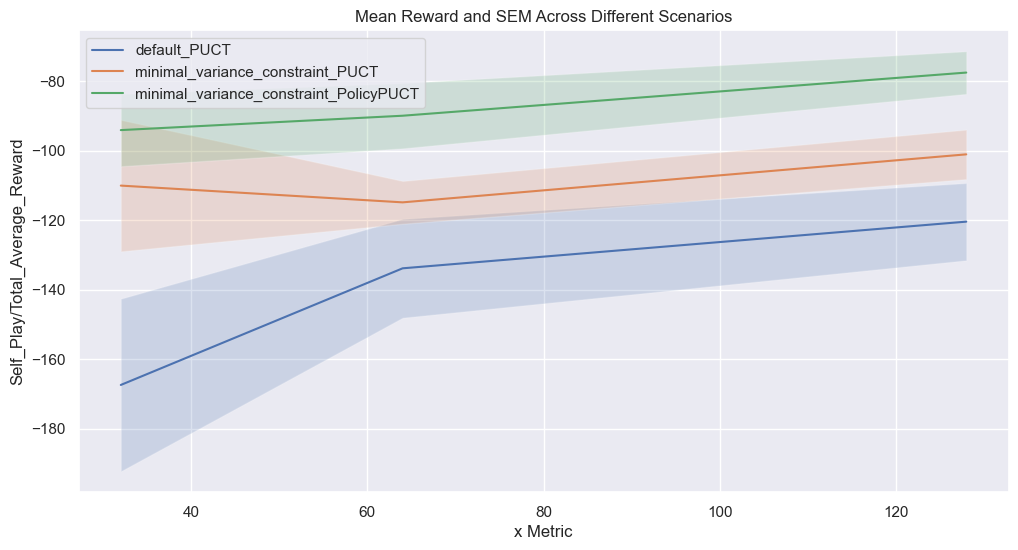

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming df is your DataFrame
# metric = "Self_Play/Max_Reward"
# group_by = ["tree_evaluation_policy", "selection_policy", x_metric]

# Example DataFrame structure (replace this with your actual data)
# df = pd.DataFrame({
#     'tree_evaluation_policy': [...],
#     'selection_policy': [...],
#     x_metric: [...],
#     'Self_Play/Max_Reward': [...]
# })

# Grouping by the specified columns
group_by = ["tree_evaluation_policy", "selection_policy", x_metric]  # Replace 'x_metric' with actual column name
groups = df.groupby(group_by)

# Preparing data for plotting
plot_data = []
for name, group in groups:
    scenario_label = f"{name[0]}_{name[1]}"  # Custom label for each scenario
    for x_value in group[x_metric].unique():
        sub_group = group[group[x_metric] == x_value]
        mean_reward = sub_group[metric].mean()
        sem_reward = sub_group[metric].sem()  # Standard Error of the Mean
        plot_data.append([scenario_label, x_value, mean_reward, sem_reward])

# Creating a DataFrame for plotting
plot_df = pd.DataFrame(plot_data, columns=['Scenario', 'x Value', 'Mean Reward', 'SEM Reward'])

# Plotting
plt.figure(figsize=(12, 6))

for scenario in plot_df['Scenario'].unique():
    scenario_data = plot_df[plot_df['Scenario'] == scenario]
    x = scenario_data['x Value']
    y = scenario_data['Mean Reward']
    sem = scenario_data['SEM Reward']

    # Linear interpolation for mean
    f_mean = interp1d(x, y, kind='linear')
    xnew = np.linspace(min(x), max(x), num=100, endpoint=True)
    ynew = f_mean(xnew)

    # Linear interpolation for upper and lower bounds of error (SEM)
    f_upper = interp1d(x, y + sem, kind='linear')
    f_lower = interp1d(x, y - sem, kind='linear')
    ynew_upper = f_upper(xnew)
    ynew_lower = f_lower(xnew)

    # Plotting mean line and shading the SEM area
    plt.plot(xnew, ynew, label=scenario)
    plt.fill_between(xnew, ynew_lower, ynew_upper, alpha=0.2)

plt.xlabel('x Metric')  # Replace with actual x-axis label
plt.ylabel(metric)
plt.title('Mean Reward and SEM Across Different Scenarios')
plt.legend()
plt.show()


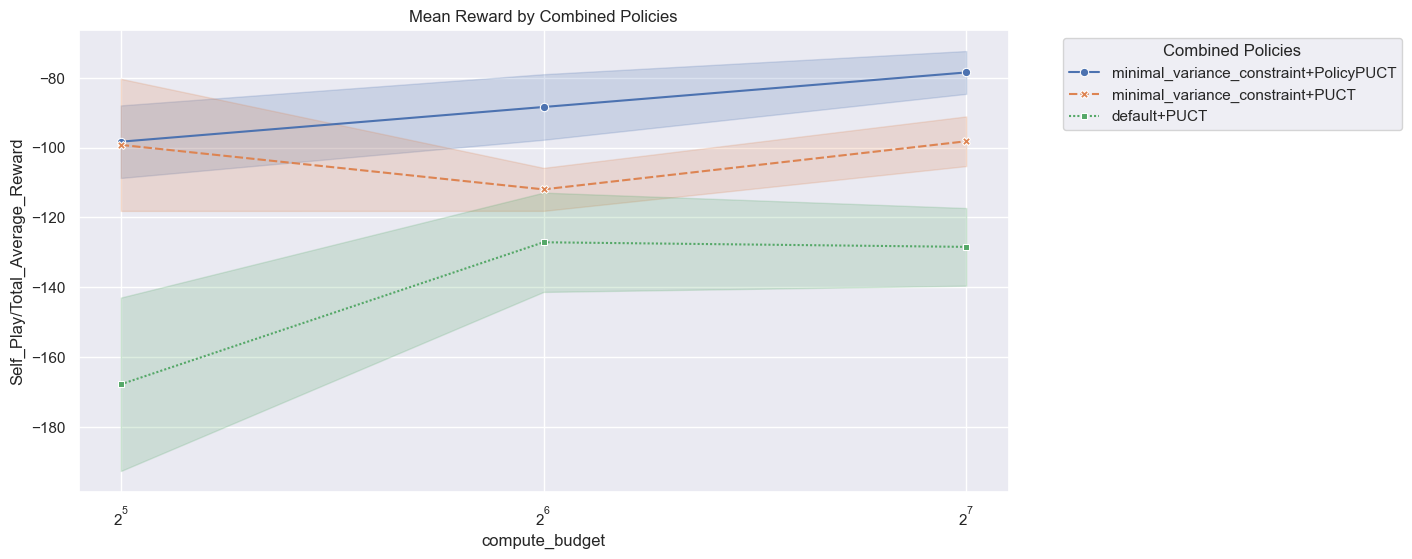

In [69]:
from turtle import st
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# x_metric and metric are variables representing the column names for x-axis and y-axis

# Combine 'tree_evaluation_policy' and 'selection_policy' into a new column
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

# Set the style of the visualization
sns.set(style="darkgrid")

# Create a line plot with confidence intervals
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=x_metric, y=metric,
             hue="policy_combination", style="policy_combination",
             markers=True, errorbar="se", estimator=np.median)

# Customize the plot with titles and labels
plt.title('Mean Reward by Combined Policies')
plt.xlabel(x_metric)  # Replace with actual x-axis label
plt.ylabel(metric)
plt.legend(title='Combined Policies', bbox_to_anchor=(1.05, 1), loc=2)
plt.gca().set_xscale('log', base=2)

# Show the plot
plt.show()
